# Transfer learning and fine-tuning

## 0. Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

print("The version of Tensorflow: {}".format(tf.__version__))

The version of Tensorflow: 2.4.1


## 1. Introduction

## 2. Freezing layers: understanding the trainable attribute

In [2]:
# Example: the Dense layer has 2 trainable weights (kernel & bias)

layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 2
non_trainable_weights: 0


In [3]:
# Example: the BatchNormalization layer has 2 trainable weights and 2 non-trainable weights

layer = keras.layers.BatchNormalization()
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 4
trainable_weights: 2
non_trainable_weights: 2


In [4]:
# Example: setting trainable to False

layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights
layer.trainable = False  # Freeze the layer

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 0
non_trainable_weights: 2


In [5]:
# When a trainable weight becomes non-trainable, its value is no longer updated during training.


# Make a model with 2 layers
layer1 = keras.layers.Dense(3, activation="relu")
layer2 = keras.layers.Dense(3, activation="sigmoid")
model = keras.Sequential([keras.Input(shape=(3,)), layer1, layer2])

# Freeze the first layer
layer1.trainable = False

# Keep a copy of the weights of layer1 for later reference
initial_layer1_weights_values = layer1.get_weights()

# Train the model
model.compile(optimizer="adam", loss="mse")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

# Check that the weights of layer1 have not changed during training
final_layer1_weights_values = layer1.get_weights()
np.testing.assert_allclose(
    initial_layer1_weights_values[0], final_layer1_weights_values[0]
)
np.testing.assert_allclose(
    initial_layer1_weights_values[1], final_layer1_weights_values[1]
)

1/1 [==============================] - 1s 612ms/step - loss: 0.1289


## 3. Recursive setting of the trainable attribut

In [6]:
# Example:

inner_model = keras.Sequential(
    [
        keras.Input(shape=(3,)),
        keras.layers.Dense(3, activation="relu"),
        keras.layers.Dense(3, activation="relu"),
    ]
)

model = keras.Sequential(
    [keras.Input(shape=(3,)), inner_model, keras.layers.Dense(3, activation="sigmoid"),]
)

model.trainable = False  # Freeze the outer model

assert inner_model.trainable == False  # All layers in `model` are now frozen
assert inner_model.layers[0].trainable == False  # `trainable` is propagated recursively

## 4. The typical transfer-learning workflow

In [7]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

In [8]:
# Then, freeze the base model.

base_model.trainable = False

In [13]:
# Create a new model on top.

inputs = keras.Input(shape=(150, 150, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [ ]:
# Train the model on new data.

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
model.fit(new_dataset, epochs=20, callbacks=..., validation_data=...)

## 5. Fine-tuning

In [ ]:
# This is how to implement fine-tuning of the whole base model:

# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

# Train end-to-end. Be careful to stop before you overfit!
model.fit(new_dataset, epochs=10, callbacks=..., validation_data=...)

## 6. Transfer learning & fine-tuning with a custom training loop

In [ ]:
# Create base model
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False)
# Freeze base model
base_model.trainable = False

# Create new model on top.
inputs = keras.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam()

# Iterate over the batches of a dataset.
for inputs, targets in new_dataset:
    # Open a GradientTape.
    with tf.GradientTape() as tape:
        # Forward pass.
        predictions = model(inputs)
        # Compute the loss value for this batch.
        loss_value = loss_fn(targets, predictions)

    # Get gradients of loss wrt the *trainable* weights.
    gradients = tape.gradient(loss_value, model.trainable_weights)
    # Update the weights of the model.
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

## 7. An end-to-end example: fine-tuning an image classification model on a cats vs. dogs dataset

### i. Getting the data

In [17]:
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Dataset cats_vs_dogs downloaded and prepared to C:\Users\admin\tensorflow_datasets\cats_vs_dogs\4.0.0. Subsequent calls will reuse this data.
Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


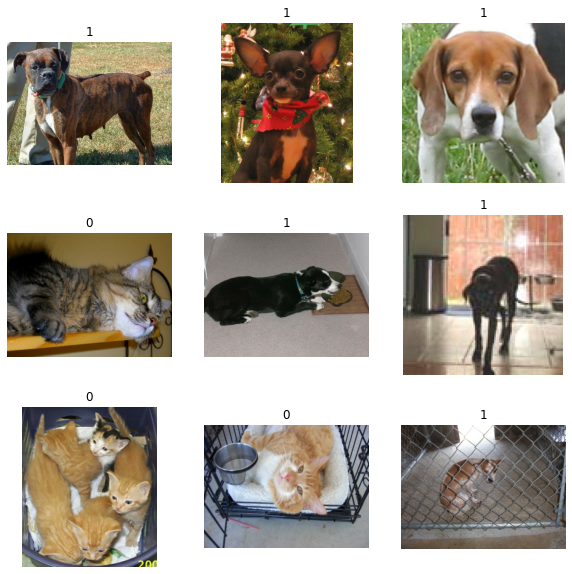

In [18]:
# These are the first 9 images in the training dataset -- as you can see, they're all different sizes.

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

## ii. Standardizing the data

In [19]:
# Let's resize images to 150x150:

size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [20]:
# Besides, let's batch the data and use caching & prefetching to optimize loading speed.

batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

### iii. Using random data augmentation

In [21]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

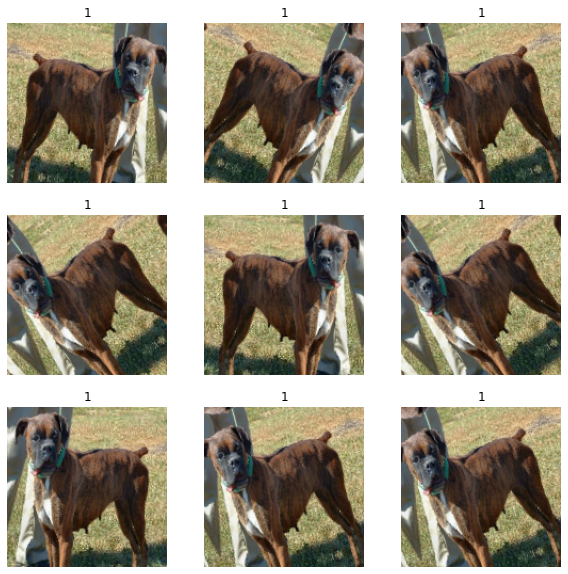

In [22]:
# Let's visualize what the first image of the first batch looks like after various random transformations:

import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

## 8. Build a model

In [23]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 2049

## 9. Train the top layer

In [24]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
291/291 [==============================] - 26s 76ms/step - loss: 0.2357 - binary_accuracy: 0.8895 - val_loss: 0.0821 - val_binary_accuracy: 0.9678
Epoch 2/20
291/291 [==============================] - 20s 68ms/step - loss: 0.1200 - binary_accuracy: 0.9495 - val_loss: 0.0788 - val_binary_accuracy: 0.9686
Epoch 3/20
291/291 [==============================] - 20s 69ms/step - loss: 0.1123 - binary_accuracy: 0.9503 - val_loss: 0.0749 - val_binary_accuracy: 0.9690
Epoch 4/20
291/291 [==============================] - 20s 69ms/step - loss: 0.1068 - binary_accuracy: 0.9544 - val_loss: 0.0731 - val_binary_accuracy: 0.9716
Epoch 5/20
291/291 [==============================] - 20s 69ms/step - loss: 0.1024 - binary_accuracy: 0.9577 - val_loss: 0.0727 - val_binary_accuracy: 0.9733
Epoch 6/20
291/291 [==============================] - 20s 70ms/step - loss: 0.1075 - binary_accuracy: 0.9510 - val_loss: 0.0712 - val_binary_accuracy: 0.9716
Epoch 7/20
291/291 [==============================] 

## 10. Do a round of fine-tuning of the entire model

In [25]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 2049

# reference

### https://tensorflow.google.cn/guide/keras/transfer_learning